In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.metrics import classification_report

In [133]:
df=pd.read_csv("housing.csv")
df.shape

(20640, 10)

In [134]:
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [135]:
df.isnull().sum()


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [136]:
df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].median())
df.isnull().sum()


longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [137]:
df.duplicated().sum()

np.int64(0)

In [138]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [139]:
def cap_outliers_with_report(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    print("Outlier counts BEFORE capping:")
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        print(f"{col}: {outliers.shape[0]}")
        
        
        df[col] = df[col].clip(lower, upper)
    
    print("\nOutlier counts AFTER capping:")
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        print(f"{col}: {outliers.shape[0]}")
    
    return df

df = cap_outliers_with_report(df)


Outlier counts BEFORE capping:
longitude: 0
latitude: 0
housing_median_age: 0
total_rooms: 1287
total_bedrooms: 1306
population: 1196
households: 1220
median_income: 681
median_house_value: 1071

Outlier counts AFTER capping:
longitude: 0
latitude: 0
housing_median_age: 0
total_rooms: 0
total_bedrooms: 0
population: 0
households: 0
median_income: 0
median_house_value: 0


Skewed columns: ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

Skewness Before and After Transformation:
total_rooms               Before =   0.84 After =   0.10
total_bedrooms            Before =   0.86 After =   0.14
population                Before =   0.84 After =   0.11
households                Before =   0.84 After =   0.10
median_income             Before =   0.74 After =   0.24
median_house_value        Before =   0.91 After =   0.40


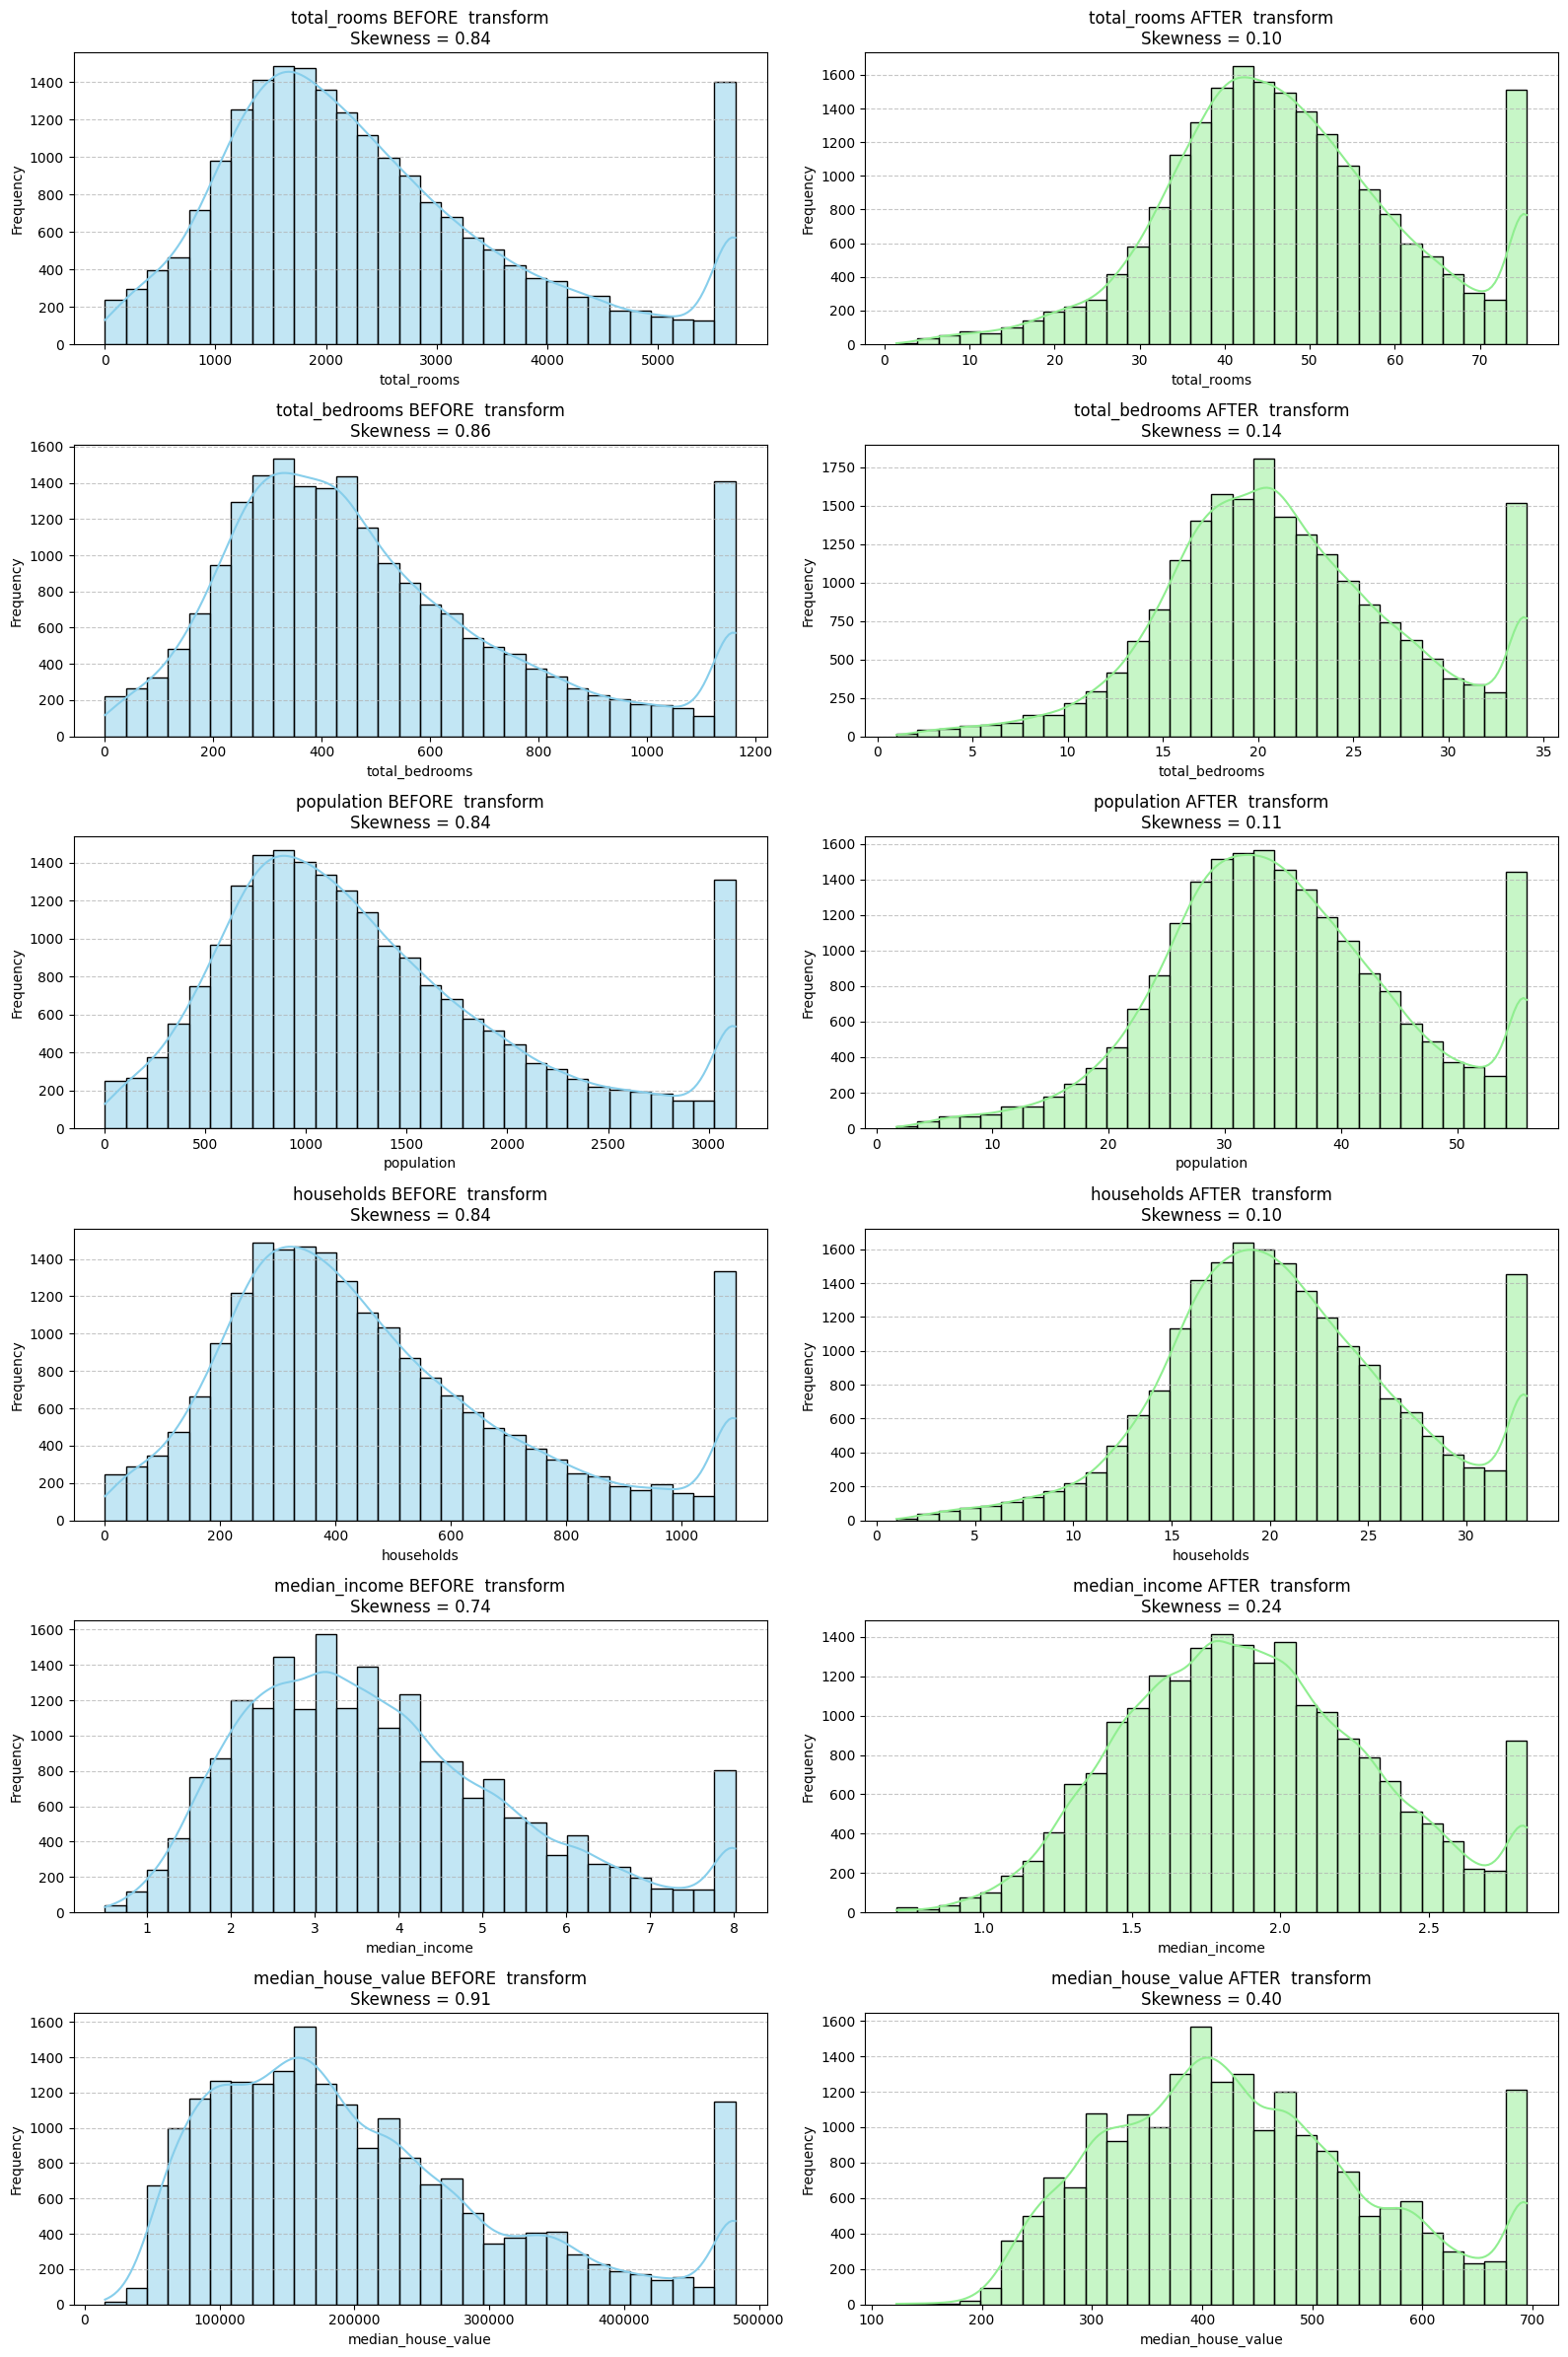

In [140]:
from scipy.stats import skew

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

skew_values_before = df[num_cols].apply(lambda x: skew(x.dropna()))

skewed_cols = skew_values_before[skew_values_before > 0.5].index.tolist()
print("Skewed columns:", skewed_cols)

df[skewed_cols] = df[skewed_cols].apply(lambda x: np.sqrt(x))

skew_values_after = df[skewed_cols].apply(lambda x: skew(x.dropna()))

print("\nSkewness Before and After Transformation:")
for col in skewed_cols:
    print(f"{col:25s} Before = {skew_values_before[col]:6.2f} After = {skew_values_after[col]:6.2f}")

plt.figure(figsize=(16, 4 * len(skewed_cols)))

for i, col in enumerate(skewed_cols):
    plt.subplot(len(skewed_cols), 2, 2*i + 1)
    sns.histplot((df[col] ** 2), bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title(f"{col} BEFORE  transform\nSkewness = {skew_values_before[col]:.2f}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.subplot(len(skewed_cols), 2, 2*i + 2)
    sns.histplot(df[col], bins=30, kde=True, color='lightgreen', edgecolor='black')
    plt.title(f"{col} AFTER  transform\nSkewness = {skew_values_after[col]:.2f}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


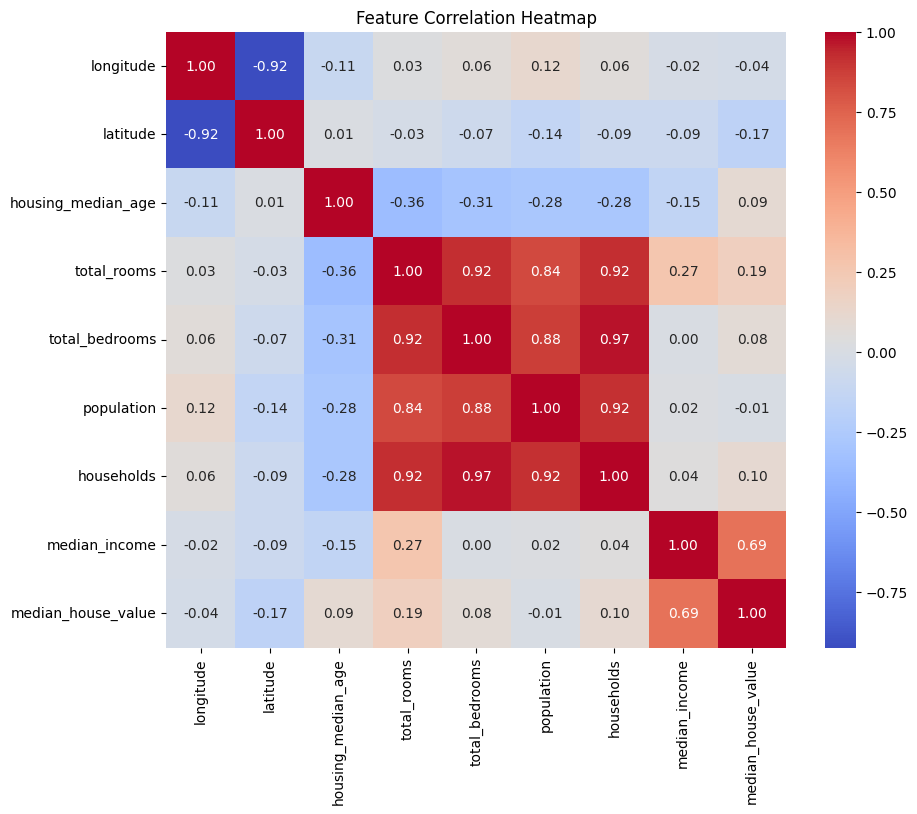

In [141]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [142]:
df = pd.get_dummies(df, columns=["ocean_proximity"], drop_first=True)

X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(objective='reg:squarederror', random_state=42)

params = {
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200],
    'max_depth': [3, 5]
}

grid = GridSearchCV(model, params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

best = grid.best_estimator_
y_pred = best.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Results:")
print("RMSE:", round(rmse, 2))
print("MAE:", round(mae, 2))
print("R² Score:", round(r2, 2))



Model Evaluation Results:
RMSE: 47.09
MAE: 32.78
R² Score: 0.85


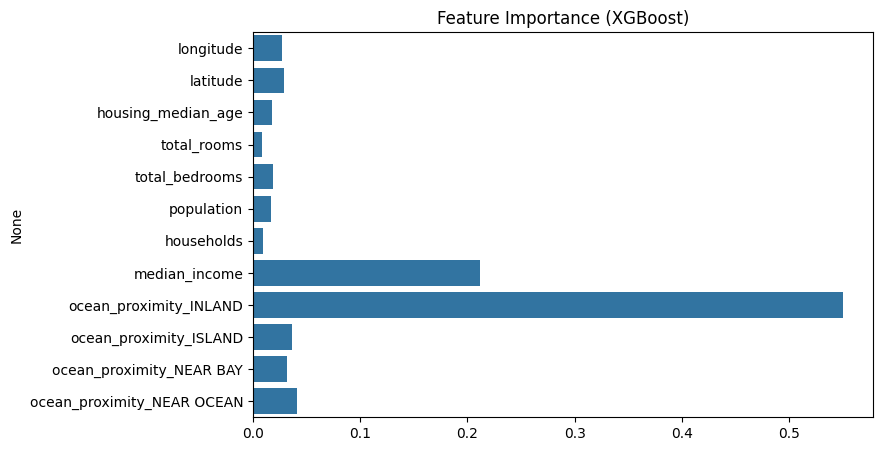

In [143]:
plt.figure(figsize=(8,5))
sns.barplot(x=best.feature_importances_, y=X.columns)
plt.title("Feature Importance (XGBoost)")
plt.show()

In [144]:
import pickle
with open('xgb_house_model.pkl', 'wb') as f:
    pickle.dump(best, f)